In [53]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def rolling_scaled_sigmoid(x: float, mean: float, std: float) -> float:
    """使用Z-score标准化后进行scaled sigmoid变换"""
    if std == 0:  # 防止除以零
        return scaled_sigmoid(x, mean, mean + 1e-10)  # 如果标准差为0，则返回相对值

    z_score = (x - mean) / std
    return scaled_sigmoid(z_score, -1, 1)  # 将Z-score映射到[-1, 1]区间


def rolling_normalize_data(df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_normalized = df.copy()

    for column in ['price', 'sum_buy_size', 'sum_sell_size', 'timestamp_duration', 'price_pct_change',
                   'buy_sell_imbalance']:
        rolling_mean = df_normalized[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_normalized[column].rolling(window=window, min_periods=1).std()

        df_normalized[f'scaled_{column}'] = 0.5  # 或者其他合适的默认值

        # 使用滚动均值和标准差进行scaled sigmoid归一化
        for i in range(len(df_normalized)):
            if i > 0:  # 从第二行开始应用归一化
                df_normalized.loc[i, f'scaled_{column}'] = rolling_scaled_sigmoid(
                    df_normalized.loc[i, column],
                    rolling_mean.iloc[i],
                    rolling_std.iloc[i]
                )

    return df_normalized
    

def scaled_sigmoid(x: float, start: float, end: float) -> float:
    """当`x`落在`[start,end]`区间时，函数值为[0,1]且在该区间有较好的响应灵敏度"""
    n = np.abs(start - end)
    score = 2 / (1 + np.exp(-np.log(40_000) * (x - start - n) / n + np.log(5e-3)))
    return score / 2


def generate_px_pct_bar(
        df: pd.DataFrame,
        threshold: float,
        window: int,
) -> pd.DataFrame:
    last_px = df.iloc[0]["price"]
    last_ts = df.iloc[0]["transact_time"]

    bars = []
    sum_buy_size = 0
    sum_sell_size = 0

    print(last_px)
    for i, row in tqdm(df.iterrows(), desc='Processing bars', total=len(df)):
        px = row["price"]
        sz = row["quantity"]
        ts = row["transact_time"]
        side = -1 if row["is_buyer_maker"] else 1  # 卖方主导为 -1，买方主导为 1

        px_pct = (px - last_px) / last_px

        if side == 1:
            sum_buy_size += sz

        else:
            sum_sell_size += sz

        if abs(px_pct) > threshold:
            ts_duration = ts - last_ts

            bar = {
                "price": px,
                "sum_buy_size": sum_buy_size,
                "sum_sell_size": sum_sell_size,
                "timestamp_duration": ts_duration,
                "price_pct_change": px_pct,
                'buy_sell_imbalance': sum_buy_size - sum_sell_size,
                "change_side": 1 if px_pct > 0 else 0,
            }
            bars.append(bar)

            last_px = px
            last_ts = ts
            sum_buy_size = 0
            sum_sell_size = 0

    bars_df = pd.DataFrame(bars)
    bars_df['future_price_pct_change'] = bars_df['price'].shift(-window) / bars_df['price'] - 1
    bars_df['scaled_sigmoid_future_price_pct_change'] = bars_df['future_price_pct_change'].apply(
        lambda x: scaled_sigmoid(x, -threshold * float(window), threshold * float(window))
    )
    
    bars_df = bars_df.dropna()

    return bars_df


def normalize_data(df: pd.DataFrame) -> pd.DataFrame:
    df_normalized = df.copy()

    df_normalized['scaled_sigmoid_price'] = df_normalized['price'].apply(
        lambda x: scaled_sigmoid(x, 0, 20)
    )
    df_normalized['scaled_sigmoid_sum_buy_size'] = df_normalized['sum_buy_size'].apply(
        lambda x: scaled_sigmoid(x, 0, 100_000)
    )
    df_normalized['scaled_sigmoid_sum_sell_size'] = df_normalized['sum_sell_size'].apply(
        lambda x: scaled_sigmoid(x, 0, 100_000)
    )
    df_normalized['scaled_sigmoid_timestamp_duration'] = df_normalized['timestamp_duration'].apply(
        lambda x: scaled_sigmoid(x, 0, 30_000)
    )
    df_normalized['scaled_sigmoid_price_pct_change'] = df_normalized['price_pct_change'].apply(
        lambda x: scaled_sigmoid(x, -0.01, 0.01)
    )
    df_normalized['scaled_sigmoid_buy_sell_imbalance'] = df_normalized['buy_sell_imbalance'].apply(
        lambda x: scaled_sigmoid(x, -100_000, 100_000)
    )
    return df_normalized

print("function imported")

function imported


In [43]:
import pandas as pd 
pd.set_option("display.max_rows", 5000)
pd.set_option("expand_frame_repr", False)

agg_trade_data = pd.read_csv("C:/Work Files/data/backtest/aggtrade/FILUSDT/FILUSDT-aggTrades-2024-04.csv")
print(agg_trade_data)

         agg_trade_id  price  quantity  first_trade_id  last_trade_id  transact_time  is_buyer_maker
0           272637339  9.972     115.9       632223322      632223326  1711929600021           False
1           272637340  9.973      11.0       632223327      632223328  1711929600027           False
2           272637341  9.973      24.8       632223329      632223333  1711929600232           False
3           272637342  9.973      74.5       632223334      632223335  1711929604764            True
4           272637343  9.974      44.6       632223336      632223340  1711929605043           False
...               ...    ...       ...             ...            ...            ...             ...
5790731     278428070  5.623     142.1       656988318      656988324  1714521596497            True
5790732     278428071  5.622      17.7       656988325      656988325  1714521597538            True
5790733     278428072  5.622       1.8       656988326      656988326  1714521597733       

In [44]:
px_pct_bar = generate_px_pct_bar(
        df=agg_trade_data,
        threshold=0.001,
        window=5,
    )

print(px_pct_bar)

9.972


Processing bars: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5790736/5790736 [02:20<00:00, 41264.44it/s]


         price  sum_buy_size  sum_sell_size  timestamp_duration  price_pct_change  buy_sell_imbalance  change_side  future_price_pct_change  scaled_sigmoid_future_price_pct_change
0        9.982       21876.6         7796.3               54203          0.001003             14080.3            1                 0.005310                                0.996411
1        9.992       57859.1        39767.9              151583          0.001002             18091.2            1                 0.005404                                0.996753
2       10.002       31156.3        31533.7               79485          0.001001              -377.4            1                 0.005499                                0.997062
3       10.013       35813.9        15303.5               50297          0.001100             20510.4            1                 0.003296                                0.970469
4       10.024       53677.6        42555.4              121349          0.001099             11122.

In [54]:
normalized_bar = rolling_normalize_data(px_pct_bar, 200)
print(normalized_bar)

         price  sum_buy_size  sum_sell_size  timestamp_duration  price_pct_change  buy_sell_imbalance  change_side  future_price_pct_change  scaled_sigmoid_future_price_pct_change  scaled_price  scaled_sum_buy_size  scaled_sum_sell_size  scaled_timestamp_duration  scaled_price_pct_change  scaled_buy_sell_imbalance
0        9.982       21876.6         7796.3               54203          0.001003             14080.3            1                 0.005310                                0.996411      0.500000             0.500000              0.500000                   0.500000                 0.500000                   0.500000
1        9.992       57859.1        39767.9              151583          0.001002             18091.2            1                 0.005404                                0.996753      0.976943             0.976943              0.976943                   0.976943                 0.023057                   0.976943
2       10.002       31156.3        31533.7         

In [50]:
normalized_bar = normalize_data(px_pct_bar)
print(normalized_bar)

         price  sum_buy_size  sum_sell_size  timestamp_duration  price_pct_change  buy_sell_imbalance  change_side  future_price_pct_change  scaled_sigmoid_future_price_pct_change  scaled_sigmoid_price  scaled_sigmoid_sum_buy_size  scaled_sigmoid_sum_sell_size  scaled_sigmoid_timestamp_duration  scaled_sigmoid_price_pct_change  scaled_sigmoid_buy_sell_imbalance
0        9.982       21876.6         7796.3               54203          0.001003             14080.3            1                 0.005310                                0.996411              0.497616                     0.048331                      0.011293                           0.999999                         0.629791                           0.678311
1        9.992       57859.1        39767.9              151583          0.001002             18091.2            1                 0.005404                                0.996753              0.498940                     0.696947                      0.252701            

In [29]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X = normalized_bar[[
    'scaled_sigmoid_price',
    'scaled_sigmoid_sum_buy_size',
    'scaled_sigmoid_sum_sell_size',
    'scaled_sigmoid_timestamp_duration',
    'scaled_sigmoid_price_pct_change',
    'scaled_sigmoid_buy_sell_imbalance',
    'change_side',
]]

y = px_pct_bar['scaled_sigmoid_future_price_pct_change']

total_index = len(X) - 1
assert total_index == len(y) - 1

train_index = int(total_index * 0.7)

X_train, X_test, y_train, y_test = X.iloc[:train_index], X.iloc[train_index:], y.iloc[:train_index], y.iloc[train_index:]
print(X_train, X_test, y_train, y_test)

print(y)
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)

print("Lasso Coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)

# 测试集上进行预测
y_pred = lasso.predict(X_test)

       scaled_sigmoid_price  scaled_sigmoid_sum_buy_size  scaled_sigmoid_sum_sell_size  scaled_sigmoid_timestamp_duration  scaled_sigmoid_price_pct_change  scaled_sigmoid_buy_sell_imbalance  change_side
0                  0.497616                     0.048331                      0.011293                           0.999999                         0.629791                           0.678311            1
1                  0.498940                     0.696947                      0.252701                           1.000000                         0.629667                           0.722827            1
2                  0.500265                     0.119540                      0.123813                           1.000000                         0.629543                           0.495001            1
3                  0.501722                     0.181941                      0.024683                           0.999996                         0.641688                           0.74776

In [30]:
ic_values = {}
for column in X.columns:
    # 只选择当前因子
    X_single = X_test[[column]]  # 只选择当前因子
    
    # 使用 lasso 进行预测
    lasso_single = Lasso(alpha=0.0001)
    lasso_single.fit(X_train[[column]], y_train)  # 只使用单一因子训练模型
    y_pred_single = lasso_single.predict(X_single)  # 预测
    
    # 计算因子的收益（因子值的排名）
    factor_return = pd.Series(y_pred_single).rank() / len(y_pred_single)  # 归一化因子预测值
    actual_return = y_test.values  # 实际收益
    
    # 计算 IC
    ic = factor_return.corr(pd.Series(actual_return))  # 计算因子收益与实际收益的相关性
    ic_values[column] = ic

# 打印每个因子的 IC 值
for factor, ic in ic_values.items():
    print(f"IC for {factor}: {ic}")

IC for scaled_sigmoid_price: 0.027068937759905872
IC for scaled_sigmoid_sum_buy_size: 5.937211951802309e-17
IC for scaled_sigmoid_sum_sell_size: 5.937211951802309e-17
IC for scaled_sigmoid_timestamp_duration: 0.025069036067281482
IC for scaled_sigmoid_price_pct_change: 0.020624957748113446
IC for scaled_sigmoid_buy_sell_imbalance: 0.00697190527360281
IC for change_side: 0.011807841258094249


In [31]:
corr_matrix = X.corrwith(y)
print(corr_matrix)


scaled_sigmoid_price                -0.013190
scaled_sigmoid_sum_buy_size         -0.003209
scaled_sigmoid_sum_sell_size         0.001589
scaled_sigmoid_timestamp_duration   -0.014134
scaled_sigmoid_price_pct_change     -0.147358
scaled_sigmoid_buy_sell_imbalance   -0.008407
change_side                         -0.094693
dtype: float64


In [32]:
print("y_test has NaN:", y_test.isnull().any())
print("y_predict has NaN:", np.isnan(y_pred).any())


y_test has NaN: False
y_predict has NaN: False


In [33]:
from sklearn.metrics import mean_squared_error, r2_score

# 计算均方误差 (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 计算 R²（决定系数）
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")


Mean Squared Error: 0.12453695778851054
R²: 0.0028666454260016794


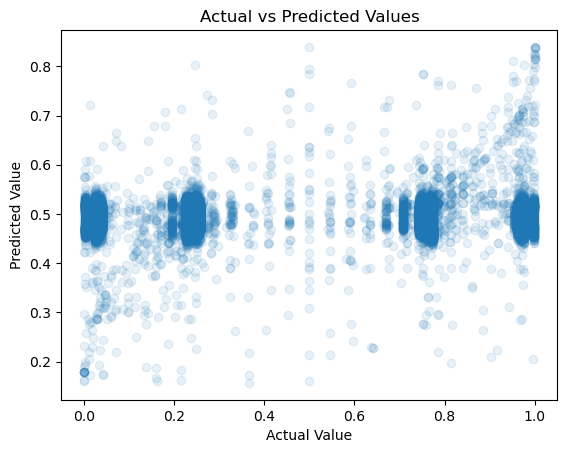

In [34]:
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted Values")
plt.show()


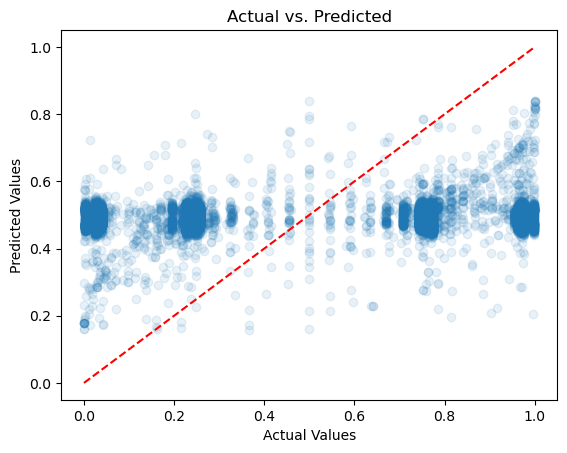

In [35]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # 对角线
plt.show()


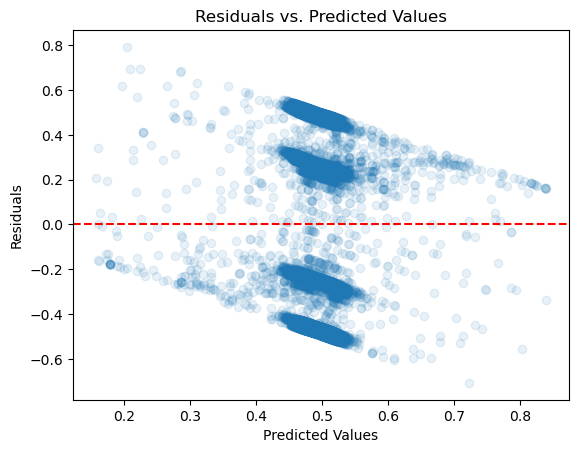

In [36]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.1)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


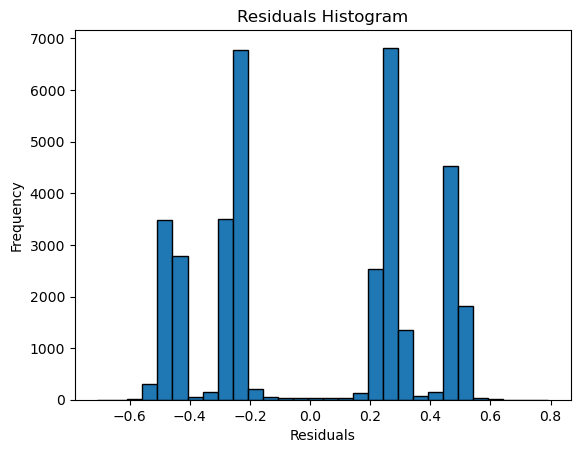

In [37]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residuals Histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [39]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R²: {r_squared}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 0.12453695778851054
Root Mean Squared Error: 0.35289794245434547
R²: 0.0028666454260016794
Mean Absolute Error: 0.3353667899568384


C:\Users\trade\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


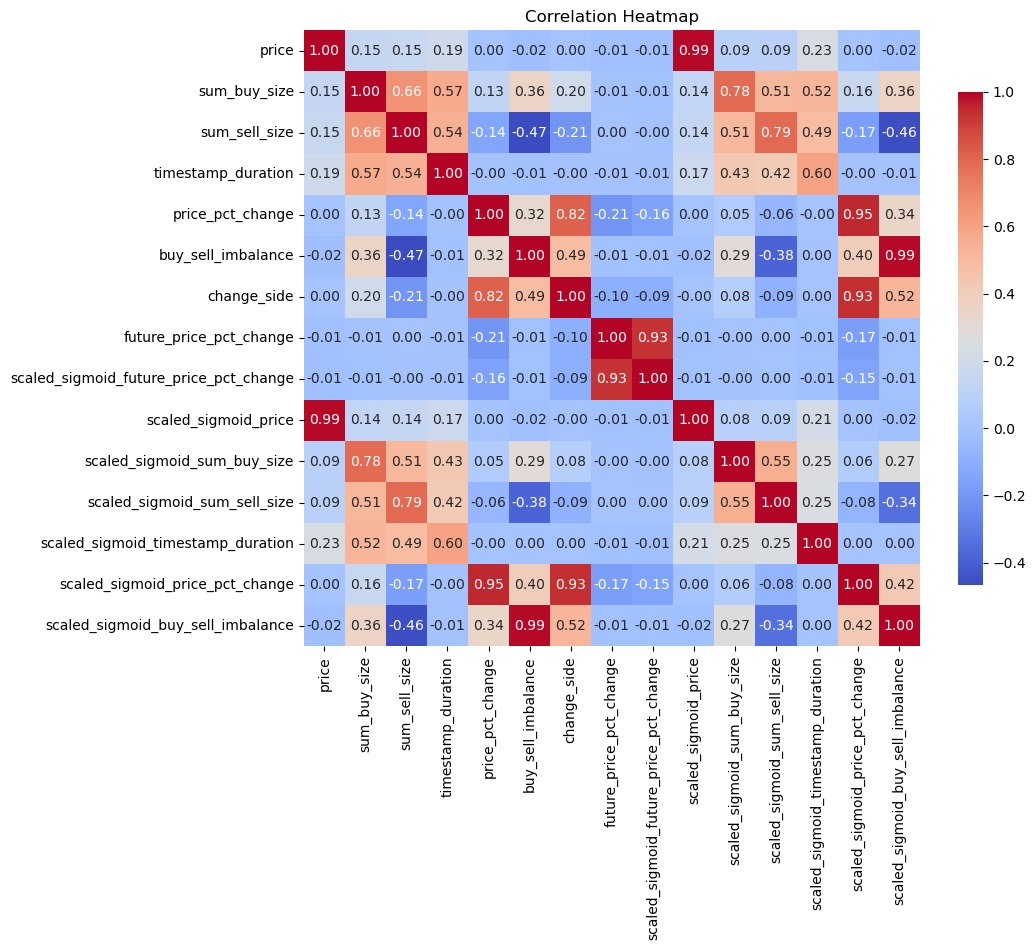

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算相关性矩阵
correlation_matrix = normalized_bar.corr()

# 创建热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap")
plt.show()
